In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.txt','\t')

In [3]:
normalized_data = data.copy()
# normalize X
high = data['X'].max()
low = data['X'].min()
normalized_data['X'] = ((data['X'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# normalize Y
high = data['Y'].max()
low = data['Y'].min()
normalized_data['Y'] = ((data['Y'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# timestamp / 40
normalized_data['timestamp'] = (data['timestamp'] / 40).map(int)

In [4]:
normalized_data.to_csv('data_normalized.csv')

In [27]:

list(map(lambda tup: tup[0],candidate_id_counts.items()))

[3,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185,
 186,
 187

In [32]:
# functions for generate a batch of sample
'''
    Input:
        data: the CSV
        num_data: size of batch
    Output:
        IDs: list of selected IDs
        input_sequence: batch with shape (num_data,input_length, 2)
        output_sequence: batch with shape (num_data, output_length, 2)
'''
from random import shuffle
def get_batch(data,num_data = 128,input_length = 8, output_length = 4):
    # evaluate the total length of series required
    total_length = input_length + output_length
    # filter out the series that has at least the number of `total_length` long
    id_counts = data.groupby('ID').ID.count()
    # get a table of candidate id, whose sequence is longer than (or eq. to) total_length
    candidate_id_counts = id_counts[id_counts >= total_length]
    # get the random sequence...
    # the candidate_id_counts is a series with ID as x and count as y
    # to get the usable indices, get list series as a list of tuple like (id, count),
    # then take the first one (list of id)
    # and make it a list, and shuffle on it
    random_ids_selected = list(map(lambda tup: tup[0],candidate_id_counts.items()))
    shuffle(random_ids_selected)
    
    selected_ids = []
    input_batch = []
    target_batch = []
    # retrieve the coordinates of the sequence (from the beginning to `total_length`)
    for i in random_ids_selected[:num_data]:
        selected_ids.append(i)
        # select X,Y from ID where ID == i order by timestamp...
        sequence_of_i = data[data.ID == i].sort_values(by = "timestamp")[["X","Y"]]
        # divide the sequence into two parts...
        input_sequence = sequence_of_i.iloc[:input_length]
        target_sequence = sequence_of_i.iloc[input_length:total_length]
        # and append the new sequence to existing arrays
        input_batch.append(np.array(input_sequence))
        target_batch.append(np.array(target_sequence))
    
    # return and array of selected ids as well as the batch...
    return np.stack(selected_ids), np.stack(input_batch), np.stack(target_batch)
    

# verify the shape is right...
list(map(lambda a: a.shape,get_batch(normalized_data)))
    

[(128,), (128, 8, 2), (128, 4, 2)]

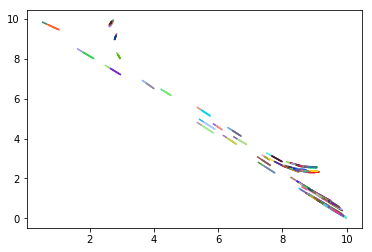

In [34]:
'''
    Visualize the traces in a batch
    If batch size = B, sequence length = L...
    Input:
        batch: batch of sequence of arbitrary length, i.e. array of shape (B,L,2)
    Output:
        None, a graph will be drawn instead..
'''

import matplotlib.pyplot as plt
def visualize_trace(batch,target_batch):
    # first we make sure that the shape of the batch looks like (_, _, 2)
    def check_shape(shape):
        if len(shape) != 3:
            raise ValueError("batch should be in 3 dimension")
        if shape[-1] != 2:
            raise ValueError("Last axis should be storing X,Y coordinates")
    
    check_shape(batch.shape)
    check_shape(target_batch.shape)
    # sub-routine for draw a particular batch
    def draw_batch(batch,linestyle = None):
        # now extract the dimension
        batch_size, sequence_length, _ = batch.shape
        for batch_id in range(batch_size):
            # pick a random color for this trace
            line_color = np.random.rand(3)
            for sequence_pos in range(sequence_length - 1):
                # get the two adjacent coordinates
                cur_coord = batch[batch_id, sequence_pos]
                next_coord = batch[batch_id, sequence_pos + 1]
                # and draw the line...
                # sneaky plot function requires x-coordinates to be put in the same argument, so are y-coordinates...
                plt.plot([cur_coord[0],next_coord[0]],
                         [cur_coord[1],next_coord[1]],
                         linestyle = linestyle,
                         c = line_color)
    
    draw_batch(batch)
    draw_batch(target_batch, ":")
    # finally show the graph
#     plt.show()
    
# let's test this visualization,
_, input_batch, target_batch = get_batch(normalized_data,128,16,8)
visualize_trace(input_batch,target_batch)

In [35]:
# now lets define a vanilla LSTM model
'''
    According to the paper, there should be an RNN that takes a sequence and gives a sequence (like seq-to-seq)
    except this output are hidden layers, like vectors of length 128
    To interpret such result, a dense layer with ReLU is added to condense the output to 5 numbers,
    namely, the mean_x, mean_y, sxx, syy, and sxy 
    of the bivariate gaussian of the probability of the agent at that given timestamp.
    
    The negative log likelihood between the real coordinate and this estimated distribution will be the loss.
'''
# first, the loss function, in Keras backend
from keras.layers import *
import keras.backend as K
'''
    The function takes a series of params of bivariate normal distribution, and a batch of observed coordinates,
    and return the log likelikhood of them...
    
    probability (likelihood) of the observed point (x,y) given the 5 parameters (mx,my,sx,sy,sp):
        det(2 * pi * [[sx,sp],[sp,sy]]) ^(-0.5) 
            * exp(-0.5 * ((x,y) - (mx,my)).T * [[sx,sp],[sp,sy]] * ((x,y) - (mx,my)))
    
    after taking log and add a minus (* -1)...
        -( (-0.5 * log(4 * pi ^ 2 * sx * sy - sp * sp)) + (-0.5 * (...)))
    
    If batch size = B, sequence length = D...
    Input:
        Batch bivariate parameters (estimated): K.variable with shape (B,D,5),
        Batch of overserved coordinates (label): K.variable with shape (B,D,2)
    
    Output:
        a scaler (K.variable with shape ()), which is the sum of negative log likelihood
'''

def negative_log_likelihood_loss(batch_observed_coordinates,batch_bivariate_params):
    # first check the dimension...
    input_shape = K.int_shape(batch_bivariate_params)
    target_shape = K.int_shape(batch_observed_coordinates)
    
    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")
    
    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")
    
    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")
    
    if input_shape[2] != 5:
        raise ValueError("Number of predicted parameters should be 5. Namely, (mx,my,sx,sy,sp)")
    
    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
    # then split the tensors into (mx,my,sx,sy,sp)...
    # all of them should be of shape (B,D)
    batch_mx = batch_bivariate_params[:,:,0]
    batch_my = batch_bivariate_params[:,:,1]
    batch_sx = batch_bivariate_params[:,:,2]
    batch_sy = batch_bivariate_params[:,:,3]
    batch_sp = batch_bivariate_params[:,:,4]
    
    batch_x = batch_observed_coordinates[:,:,0]
    batch_y = batch_observed_coordinates[:,:,1]
    
    dx = batch_x - batch_mx # (B,D), (x - mx)
    dy = batch_y - batch_my # (B,D), (y - my)
    dydx = Multiply()([dx,dy])
    
    batch_x_change =  K.concatenate([batch_mx[:,0:1], batch_mx[:,1:] - batch_mx[:,:-1]])
    batch_y_change =  K.concatenate([batch_my[:,0:1], batch_my[:,1:] - batch_my[:,:-1]])
    target_x_change =  K.concatenate([batch_x[:,0:1], batch_x[:,1:] - batch_x[:,:-1]])
    target_y_change =  K.concatenate([batch_y[:,0:1], batch_y[:,1:] - batch_y[:,:-1]])
    
    xy_dot = Multiply()([batch_x_change,target_x_change]) + Multiply()([batch_y_change,target_y_change])
    batch_change_norm = K.sqrt(K.square(batch_x_change) + K.square(batch_y_change))
    target_change_norm = K.sqrt(K.square(target_x_change) + K.square(target_y_change))
    
    norm_prod = Multiply()([batch_change_norm,target_change_norm]) + 1e-6
    norm_prod_inv = K.pow(norm_prod,-1) # for numerical stability
    direction_loss =  - K.mean(Multiply()([xy_dot,norm_prod_inv]))
#     det_inv = K.print_tensor(K.pow(det,-1), message="det_inv") # (B,D), (sx * sy - sp^2) ^-1
    # (B,D), (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2)
    exp = -0.5 * Multiply()([K.square(dx),batch_sy]) - 2 * Multiply()([dydx, batch_sp]) + Multiply()([K.square(dy),batch_sx])
    # (B,D), -0.5 * (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2) * det(Cov)^(-1)
#     exp = Multiply()([det_inv,exp]) * (-0.5)
    
    # evaluate the final NLL
    '''
        A remark here: it is determined that the determininat of the covariance matrix will not be considered as a loss,
        as the value of that generally became very large (under the log function)
        therefore only the exponents are used as the loss
    '''
#     batch_nll = - (exp)
    batch_nll = K.square(dx) + K.square(dy) - 0.1 * exp + 0.1 * direction_loss
    batch_error_total = K.sum(batch_nll, axis = 1) # (B,) sum of NLL in a sequence...
    return K.print_tensor(K.mean(batch_error_total, axis = 0)) # (), average of sum of NLL...

# now test it...
# a regular 0-centered, non-skewing normal
[mx,my,sx,sy,sp] = [0,0,.1,.1,0.]
bivariate_params = np.array([[[mx,my,sx,sy,sp]]]) # (1,1,5)
target_point = np.array([[[-0.,0]]]) # (1,1,2)

bivariate_ph = K.variable(value = bivariate_params, dtype = "float32")
target_ph = K.variable(value = target_point, dtype = "float32")
nll = negative_log_likelihood_loss(target_ph,bivariate_ph)
K.eval(nll)

0.0

In [36]:
def infer_layer(batch_predicted_coordinates):
    return K.cumsum(batch_predicted_coordinates,axis = 1)
    
def check_tensor(batch_observed_coordinates,batch_predicted_coordinates):
    input_shape = K.int_shape(batch_predicted_coordinates)
    target_shape = K.int_shape(batch_observed_coordinates)

    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")

    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")

    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")

    if input_shape[2] != 2:
        raise ValueError("Number of predicted parameters should be 2. Namely, (mx,my)")

    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
def ms_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    # first check the dimension...
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    diff = K.square(batch_predicted_coordinates - batch_observed_coordinates)

    return K.sum(diff)

def dir_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    predict_dir = batch_predicted_coordinates[:,1:] - batch_predicted_coordinates[:,:-1]
    
    target_dir = batch_observed_coordinates[:,1:] - batch_observed_coordinates[:,:-1]
    
#     predic_dir_norm = 
    # this is to maximize the cosine (therefore angle = 0)
    return K.sum(K.square((predict_dir - target_dir)))

In [37]:
# then, the Vanilla LSTM
from keras.models import Model
from keras.initializers import RandomNormal
from keras import optimizers
def vanilla_lstm_model(num_hidden, input_length, predict_length, lr = 1e-3):
# def vanilla_lstm_model(num_hidden,input_length, predict_length, input_tensor, target_tensor):
    total_length = input_length + predict_length
    # the input
    input_sequence = Input(shape = (total_length,2), name = 'input_sequence', dtype = 'float32') # (T, 2)
    target_sequence = Input(shape = (total_length,2), name = 'target_sequence', dtype = 'float32') # (T, 2)
    lstm = LSTM(num_hidden, return_sequences = True)(input_sequence) # (B,T,num_hidden)
#     params = TimeDistributed(Dense(5, activation = 'elu'), name = 'params')(lstm) # (B,T,5)
    predicted_coordinates_raw = TimeDistributed(Dense(2, activation = 'elu'), name = 'params')(lstm)
    
    # retrieve the prediction
    extract_target_sequence_layer = Lambda(lambda x: x[:,input_length:,:])
    predicted_coordinates_masked = extract_target_sequence_layer(predicted_coordinates_raw)
    target_coordinates_masked = extract_target_sequence_layer(target_sequence)
    # the output layer
    predicted_output = Lambda(infer_layer, name = "predict")(predicted_coordinates_masked)
    # compute the loss
    
    # first part: the square loss
    sq_loss = Lambda(ms_loss, name = 'square_loss')([target_coordinates_masked, predicted_output])
    # second part: the direction loss
    ori_loss = Lambda(dir_loss, name = 'dir_loss')([target_coordinates_masked, predicted_output])
    
    loss = Lambda(lambda ts: ts[0] + ts[1],name = 'loss')([sq_loss, ori_loss])
    
    model = Model(
        inputs = [input_sequence,target_sequence],
        outputs = [predicted_output,loss])
    
    model.compile(optimizer=optimizers.RMSprop(lr = lr, clipvalue = 10., decay = 1e-6),
                  # since there are two outputs of the model, the estimated params and the NLL,
                  # their loss value should be specified.
                  # for params there are no loss regarding its value, but I just assign a zero as loss (or the computational graph will break)
                  # I made it loss - loss = 0.
                  # and for the NLL, return the loss as-is.
                  loss= {
                        'predict': lambda _, loss: loss - loss, # meh...
                          'loss': lambda _, loss: loss
                    })
    
    return input_sequence, target_sequence, model, predicted_output,loss




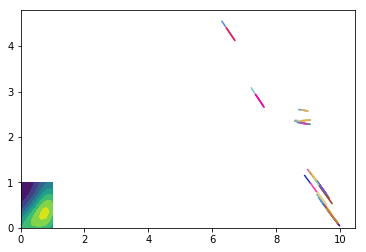

In [10]:
# helper function for monitoring training progress
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
'''
    Given a set of parameter (array of 5), visualize the heatmap of the bivariate normal distribution
'''
def draw_heatmap(params):
    resolution = 100
    interval = 1. / resolution
    
    x,y = np.mgrid[0:1:interval,0:1:interval]
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = x
    pos[:,:,1] = y
    result_distribution = None
    for param in params:
        mx,my,sx,sy,sp = param
        F = multivariate_normal([mx,my],[[sx,sp],[sp,sy]])
        result_distribution = F.pdf(pos) if result_distribution is None else result_distribution + F.pdf(pos)
    plt.contourf(x,y,result_distribution)

# try it out
# fig = plt.figure()
draw_heatmap(np.array([[0.3,0.1,0.4,0.2,.2],[0.9,0.2,0.1,0.9,0.]]))
visualize_trace(input_batch,target_batch)
# draw_heatmap(0.3,0.2,0.01,0.2,0.,fig)
plt.show()

'''
    Draw the mean of the predicted params of all timestamps
'''
import matplotlib.cm as cm
def draw_mean(params):
    plt.xlim(0,10)
    plt.ylim(0,10)
    
    
    for batch in range(params.shape[0]):
        line_color = np.random.rand(3) # choose a color to tell that these scatter points belong to the same prediction
        xy_series = params[batch,:,:] # (D,2)
        # prgressively change the color to indicate the direction
        colors = cm.rainbow(np.linspace(0, 1, params.shape[1]))
        plt.scatter(xy_series[:,0],xy_series[:,1], c = colors)

In [40]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, LambdaCallback

def get_callbacks(input_batch_padded,target_batch_padded,finetune = False):
    # prepare callbacks
    reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                  factor=0.1,
                                  patience=50, 
                                  min_lr=1e-6)
    csv_logger = CSVLogger("log.csv")

    def visualize_prediction(epoch, logs):
        params, loss = model.predict([input_batch_padded,target_batch_padded])
        # visualize the trace, as well as the distributions generated by the params...
        # first clear the previous drawing...
    #     try:
        plt.gcf().clear()
        visualize_trace(input_batch,target_batch)
    #     params = params[:,INPUT_LENGTH + 1, :] # (B,5), and it should be the params immediately after the input
    #     draw_heatmap(params)
        draw_mean(params)
        filename = '{}.png' if not finetune else '{}-finetune.png'
        plt.savefig(filename.format(epoch))

    plot_callback = LambdaCallback(on_epoch_begin = visualize_prediction)
    
    return [reduce_lr, 
            csv_logger, 
           # plot_callback
           ]

In [41]:
# now run the training!
# try to overfit a batch first...

INPUT_LENGTH = 8
OUTPUT_LENGTH = 4
TOTAL_LENGTH = INPUT_LENGTH + OUTPUT_LENGTH
BATCH_SIZE = 256

inp_ph,target_ph, model, params, loss = vanilla_lstm_model(128,
                                                           INPUT_LENGTH,
                                                           OUTPUT_LENGTH,
                                                          1e-3)
model.summary()
indices, input_batch, target_batch = get_batch(normalized_data,BATCH_SIZE,INPUT_LENGTH,OUTPUT_LENGTH)
# prepare data
input_batch_padded = np.hstack([input_batch,np.zeros((BATCH_SIZE,OUTPUT_LENGTH,2))])
target_batch_padded = np.hstack([np.zeros((BATCH_SIZE,INPUT_LENGTH,2)),target_batch])


# and train
model.fit(
    [input_batch_padded,target_batch_padded],
    [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
    epochs = 500,
    callbacks = get_callbacks(input_batch_padded,target_batch_padded)
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence (InputLayer)     (None, 12, 2)        0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   (None, 12, 128)      67072       input_sequence[0][0]             
__________________________________________________________________________________________________
params (TimeDistributed)        (None, 12, 2)        258         lstm_4[0][0]                     
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4, 2)         0           params[0][0]                     
                                                                 target_sequence[0][0]            
__________

256/256 [==============================] - 0s 480us/step - loss: 56.8364 - predict_loss: 0.0000e+00 - loss_loss: 56.8364
Epoch 42/500
256/256 [==============================] - 0s 416us/step - loss: 58.6745 - predict_loss: 0.0000e+00 - loss_loss: 58.6745
Epoch 43/500
256/256 [==============================] - 0s 405us/step - loss: 53.1601 - predict_loss: 0.0000e+00 - loss_loss: 53.1601
Epoch 44/500
256/256 [==============================] - 0s 429us/step - loss: 55.4040 - predict_loss: 0.0000e+00 - loss_loss: 55.4040
Epoch 45/500
256/256 [==============================] - 0s 524us/step - loss: 49.9378 - predict_loss: 0.0000e+00 - loss_loss: 49.9378
Epoch 46/500
256/256 [==============================] - 0s 581us/step - loss: 46.8868 - predict_loss: 0.0000e+00 - loss_loss: 46.8868
Epoch 47/500
256/256 [==============================] - 0s 500us/step - loss: 53.0918 - predict_loss: 0.0000e+00 - loss_loss: 53.0918
Epoch 48/500
256/256 [==============================] - 0s 422us/step - los

256/256 [==============================] - 0s 408us/step - loss: 15.5753 - predict_loss: 0.0000e+00 - loss_loss: 15.5753
Epoch 103/500
256/256 [==============================] - 0s 429us/step - loss: 13.6402 - predict_loss: 0.0000e+00 - loss_loss: 13.6402
Epoch 104/500
256/256 [==============================] - 0s 458us/step - loss: 15.3605 - predict_loss: 0.0000e+00 - loss_loss: 15.3605
Epoch 105/500
256/256 [==============================] - 0s 373us/step - loss: 14.9595 - predict_loss: 0.0000e+00 - loss_loss: 14.9595
Epoch 106/500
256/256 [==============================] - 0s 427us/step - loss: 17.8946 - predict_loss: 0.0000e+00 - loss_loss: 17.8946
Epoch 107/500
256/256 [==============================] - 0s 369us/step - loss: 11.7580 - predict_loss: 0.0000e+00 - loss_loss: 11.7580
Epoch 108/500
256/256 [==============================] - 0s 336us/step - loss: 14.5222 - predict_loss: 0.0000e+00 - loss_loss: 14.5222
Epoch 109/500
256/256 [==============================] - 0s 350us/ste

256/256 [==============================] - 0s 505us/step - loss: 11.3761 - predict_loss: 0.0000e+00 - loss_loss: 11.3761
Epoch 164/500
256/256 [==============================] - 0s 449us/step - loss: 7.2790 - predict_loss: 0.0000e+00 - loss_loss: 7.2790
Epoch 165/500
256/256 [==============================] - 0s 436us/step - loss: 12.4217 - predict_loss: 0.0000e+00 - loss_loss: 12.4217
Epoch 166/500
256/256 [==============================] - 0s 441us/step - loss: 8.2477 - predict_loss: 0.0000e+00 - loss_loss: 8.2477
Epoch 167/500
256/256 [==============================] - 0s 406us/step - loss: 7.3662 - predict_loss: 0.0000e+00 - loss_loss: 7.3662
Epoch 168/500
256/256 [==============================] - 0s 497us/step - loss: 10.0731 - predict_loss: 0.0000e+00 - loss_loss: 10.0731
Epoch 169/500
256/256 [==============================] - 0s 411us/step - loss: 8.2848 - predict_loss: 0.0000e+00 - loss_loss: 8.2848
Epoch 170/500
256/256 [==============================] - 0s 408us/step - loss

256/256 [==============================] - 0s 439us/step - loss: 6.3519 - predict_loss: 0.0000e+00 - loss_loss: 6.3519
Epoch 225/500
256/256 [==============================] - 0s 400us/step - loss: 8.0161 - predict_loss: 0.0000e+00 - loss_loss: 8.0161
Epoch 226/500
256/256 [==============================] - 0s 413us/step - loss: 7.7166 - predict_loss: 0.0000e+00 - loss_loss: 7.7166
Epoch 227/500
256/256 [==============================] - 0s 435us/step - loss: 6.1856 - predict_loss: 0.0000e+00 - loss_loss: 6.1856
Epoch 228/500
256/256 [==============================] - 0s 485us/step - loss: 6.6096 - predict_loss: 0.0000e+00 - loss_loss: 6.6096
Epoch 229/500
256/256 [==============================] - 0s 432us/step - loss: 6.8404 - predict_loss: 0.0000e+00 - loss_loss: 6.8404
Epoch 230/500
256/256 [==============================] - 0s 446us/step - loss: 8.0740 - predict_loss: 0.0000e+00 - loss_loss: 8.0740
Epoch 231/500
256/256 [==============================] - 0s 421us/step - loss: 5.36

256/256 [==============================] - 0s 483us/step - loss: 6.2929 - predict_loss: 0.0000e+00 - loss_loss: 6.2929
Epoch 286/500
256/256 [==============================] - 0s 405us/step - loss: 5.1188 - predict_loss: 0.0000e+00 - loss_loss: 5.1188
Epoch 287/500
256/256 [==============================] - 0s 417us/step - loss: 7.0248 - predict_loss: 0.0000e+00 - loss_loss: 7.0248
Epoch 288/500
256/256 [==============================] - 0s 410us/step - loss: 5.0436 - predict_loss: 0.0000e+00 - loss_loss: 5.0436
Epoch 289/500
256/256 [==============================] - 0s 411us/step - loss: 4.6308 - predict_loss: 0.0000e+00 - loss_loss: 4.6308
Epoch 290/500
256/256 [==============================] - 0s 455us/step - loss: 5.4040 - predict_loss: 0.0000e+00 - loss_loss: 5.4040
Epoch 291/500
256/256 [==============================] - 0s 410us/step - loss: 6.8393 - predict_loss: 0.0000e+00 - loss_loss: 6.8393
Epoch 292/500
256/256 [==============================] - 0s 410us/step - loss: 4.67

256/256 [==============================] - 0s 464us/step - loss: 4.1215 - predict_loss: 0.0000e+00 - loss_loss: 4.1215
Epoch 347/500
256/256 [==============================] - 0s 434us/step - loss: 3.9234 - predict_loss: 0.0000e+00 - loss_loss: 3.9234
Epoch 348/500
256/256 [==============================] - 0s 489us/step - loss: 5.6424 - predict_loss: 0.0000e+00 - loss_loss: 5.6424
Epoch 349/500
256/256 [==============================] - 0s 524us/step - loss: 4.4254 - predict_loss: 0.0000e+00 - loss_loss: 4.4254
Epoch 350/500
256/256 [==============================] - 0s 443us/step - loss: 4.5451 - predict_loss: 0.0000e+00 - loss_loss: 4.5451
Epoch 351/500
256/256 [==============================] - 0s 389us/step - loss: 4.3670 - predict_loss: 0.0000e+00 - loss_loss: 4.3670
Epoch 352/500
256/256 [==============================] - 0s 374us/step - loss: 4.7824 - predict_loss: 0.0000e+00 - loss_loss: 4.7824
Epoch 353/500
256/256 [==============================] - 0s 438us/step - loss: 5.36

256/256 [==============================] - 0s 452us/step - loss: 0.1984 - predict_loss: 0.0000e+00 - loss_loss: 0.1984
Epoch 408/500
256/256 [==============================] - 0s 364us/step - loss: 0.2154 - predict_loss: 0.0000e+00 - loss_loss: 0.2154
Epoch 409/500
256/256 [==============================] - 0s 379us/step - loss: 0.1877 - predict_loss: 0.0000e+00 - loss_loss: 0.1877
Epoch 410/500
256/256 [==============================] - 0s 468us/step - loss: 0.2188 - predict_loss: 0.0000e+00 - loss_loss: 0.2188
Epoch 411/500
256/256 [==============================] - 0s 311us/step - loss: 0.1870 - predict_loss: 0.0000e+00 - loss_loss: 0.1870
Epoch 412/500
256/256 [==============================] - 0s 440us/step - loss: 0.2060 - predict_loss: 0.0000e+00 - loss_loss: 0.2060
Epoch 413/500
256/256 [==============================] - 0s 420us/step - loss: 0.2043 - predict_loss: 0.0000e+00 - loss_loss: 0.2043
Epoch 414/500
256/256 [==============================] - 0s 415us/step - loss: 0.20

256/256 [==============================] - 0s 442us/step - loss: 0.1787 - predict_loss: 0.0000e+00 - loss_loss: 0.1787
Epoch 469/500
256/256 [==============================] - 0s 385us/step - loss: 0.1599 - predict_loss: 0.0000e+00 - loss_loss: 0.1599
Epoch 470/500
256/256 [==============================] - 0s 388us/step - loss: 0.1575 - predict_loss: 0.0000e+00 - loss_loss: 0.1575
Epoch 471/500
256/256 [==============================] - 0s 418us/step - loss: 0.1841 - predict_loss: 0.0000e+00 - loss_loss: 0.1841
Epoch 472/500
256/256 [==============================] - 0s 390us/step - loss: 0.1676 - predict_loss: 0.0000e+00 - loss_loss: 0.1676
Epoch 473/500
256/256 [==============================] - 0s 425us/step - loss: 0.1402 - predict_loss: 0.0000e+00 - loss_loss: 0.1402
Epoch 474/500
256/256 [==============================] - 0s 445us/step - loss: 0.1883 - predict_loss: 0.0000e+00 - loss_loss: 0.1883
Epoch 475/500
256/256 [==============================] - 0s 457us/step - loss: 0.14

In [42]:
# finetuning
model.compile(optimizer=optimizers.RMSprop(lr = 1e-5, clipvalue = 10.),
              loss= {
                    'predict': lambda _, loss: loss - loss,
                      'loss': lambda _, loss: loss
                })
# and train
model.fit(
    [input_batch_padded,target_batch_padded],
    [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
    epochs = 500,
    callbacks = get_callbacks(input_batch_padded,target_batch_padded, True)
)

Epoch 1/500
256/256 [==============================] - 0s 2ms/step - loss: 0.0857 - predict_loss: 0.0000e+00 - loss_loss: 0.0857
Epoch 2/500
256/256 [==============================] - 0s 486us/step - loss: 0.0816 - predict_loss: 0.0000e+00 - loss_loss: 0.0816
Epoch 3/500
256/256 [==============================] - 0s 497us/step - loss: 0.0821 - predict_loss: 0.0000e+00 - loss_loss: 0.0821
Epoch 4/500
256/256 [==============================] - 0s 482us/step - loss: 0.0813 - predict_loss: 0.0000e+00 - loss_loss: 0.0813
Epoch 5/500
256/256 [==============================] - 0s 453us/step - loss: 0.0821 - predict_loss: 0.0000e+00 - loss_loss: 0.0821
Epoch 6/500
256/256 [==============================] - 0s 431us/step - loss: 0.0821 - predict_loss: 0.0000e+00 - loss_loss: 0.0821
Epoch 7/500
256/256 [==============================] - 0s 479us/step - loss: 0.0815 - predict_loss: 0.0000e+00 - loss_loss: 0.0815
Epoch 8/500
256/256 [==============================] - 0s 441us/step - loss: 0.0823 -

256/256 [==============================] - 0s 469us/step - loss: 0.0763 - predict_loss: 0.0000e+00 - loss_loss: 0.0763
Epoch 64/500
256/256 [==============================] - 0s 378us/step - loss: 0.0773 - predict_loss: 0.0000e+00 - loss_loss: 0.0773
Epoch 65/500
256/256 [==============================] - 0s 396us/step - loss: 0.0775 - predict_loss: 0.0000e+00 - loss_loss: 0.0775
Epoch 66/500
256/256 [==============================] - 0s 574us/step - loss: 0.0780 - predict_loss: 0.0000e+00 - loss_loss: 0.0780
Epoch 67/500
256/256 [==============================] - 0s 558us/step - loss: 0.0762 - predict_loss: 0.0000e+00 - loss_loss: 0.0762
Epoch 68/500
256/256 [==============================] - 0s 541us/step - loss: 0.0788 - predict_loss: 0.0000e+00 - loss_loss: 0.0788
Epoch 69/500
256/256 [==============================] - 0s 431us/step - loss: 0.0764 - predict_loss: 0.0000e+00 - loss_loss: 0.0764
Epoch 70/500
256/256 [==============================] - 0s 434us/step - loss: 0.0776 - pr

Epoch 125/500
256/256 [==============================] - 0s 397us/step - loss: 0.0741 - predict_loss: 0.0000e+00 - loss_loss: 0.0741
Epoch 126/500
256/256 [==============================] - 0s 408us/step - loss: 0.0758 - predict_loss: 0.0000e+00 - loss_loss: 0.0758
Epoch 127/500
256/256 [==============================] - 0s 355us/step - loss: 0.0730 - predict_loss: 0.0000e+00 - loss_loss: 0.0730
Epoch 128/500
256/256 [==============================] - 0s 412us/step - loss: 0.0740 - predict_loss: 0.0000e+00 - loss_loss: 0.0740
Epoch 129/500
256/256 [==============================] - 0s 416us/step - loss: 0.0738 - predict_loss: 0.0000e+00 - loss_loss: 0.0738
Epoch 130/500
256/256 [==============================] - 0s 407us/step - loss: 0.0751 - predict_loss: 0.0000e+00 - loss_loss: 0.0751
Epoch 131/500
256/256 [==============================] - 0s 456us/step - loss: 0.0736 - predict_loss: 0.0000e+00 - loss_loss: 0.0736
Epoch 132/500
256/256 [==============================] - 0s 437us/ste

256/256 [==============================] - 0s 462us/step - loss: 0.0715 - predict_loss: 0.0000e+00 - loss_loss: 0.0715
Epoch 187/500
256/256 [==============================] - 0s 398us/step - loss: 0.0713 - predict_loss: 0.0000e+00 - loss_loss: 0.0713
Epoch 188/500
256/256 [==============================] - 0s 405us/step - loss: 0.0727 - predict_loss: 0.0000e+00 - loss_loss: 0.0727
Epoch 189/500
256/256 [==============================] - 0s 415us/step - loss: 0.0709 - predict_loss: 0.0000e+00 - loss_loss: 0.0709
Epoch 190/500
256/256 [==============================] - 0s 416us/step - loss: 0.0724 - predict_loss: 0.0000e+00 - loss_loss: 0.0724
Epoch 191/500
256/256 [==============================] - 0s 394us/step - loss: 0.0720 - predict_loss: 0.0000e+00 - loss_loss: 0.0720
Epoch 192/500
256/256 [==============================] - 0s 440us/step - loss: 0.0718 - predict_loss: 0.0000e+00 - loss_loss: 0.0718
Epoch 193/500
256/256 [==============================] - 0s 423us/step - loss: 0.07

256/256 [==============================] - 0s 424us/step - loss: 0.0711 - predict_loss: 0.0000e+00 - loss_loss: 0.0711
Epoch 248/500
256/256 [==============================] - 0s 425us/step - loss: 0.0688 - predict_loss: 0.0000e+00 - loss_loss: 0.0688
Epoch 249/500
256/256 [==============================] - 0s 404us/step - loss: 0.0703 - predict_loss: 0.0000e+00 - loss_loss: 0.0703
Epoch 250/500
256/256 [==============================] - 0s 443us/step - loss: 0.0699 - predict_loss: 0.0000e+00 - loss_loss: 0.0699
Epoch 251/500
256/256 [==============================] - 0s 432us/step - loss: 0.0693 - predict_loss: 0.0000e+00 - loss_loss: 0.0693
Epoch 252/500
256/256 [==============================] - 0s 343us/step - loss: 0.0703 - predict_loss: 0.0000e+00 - loss_loss: 0.0703
Epoch 253/500
256/256 [==============================] - 0s 388us/step - loss: 0.0707 - predict_loss: 0.0000e+00 - loss_loss: 0.0707
Epoch 254/500
256/256 [==============================] - 0s 387us/step - loss: 0.07

256/256 [==============================] - 0s 440us/step - loss: 0.0670 - predict_loss: 0.0000e+00 - loss_loss: 0.0670
Epoch 309/500
256/256 [==============================] - 0s 427us/step - loss: 0.0683 - predict_loss: 0.0000e+00 - loss_loss: 0.0683
Epoch 310/500
256/256 [==============================] - 0s 465us/step - loss: 0.0675 - predict_loss: 0.0000e+00 - loss_loss: 0.0675
Epoch 311/500
256/256 [==============================] - 0s 387us/step - loss: 0.0693 - predict_loss: 0.0000e+00 - loss_loss: 0.0693
Epoch 312/500
256/256 [==============================] - 0s 438us/step - loss: 0.0669 - predict_loss: 0.0000e+00 - loss_loss: 0.0669
Epoch 313/500
256/256 [==============================] - 0s 442us/step - loss: 0.0692 - predict_loss: 0.0000e+00 - loss_loss: 0.0692
Epoch 314/500
256/256 [==============================] - 0s 406us/step - loss: 0.0686 - predict_loss: 0.0000e+00 - loss_loss: 0.0686
Epoch 315/500
256/256 [==============================] - 0s 408us/step - loss: 0.06

256/256 [==============================] - 0s 449us/step - loss: 0.0667 - predict_loss: 0.0000e+00 - loss_loss: 0.0667
Epoch 370/500
256/256 [==============================] - 0s 397us/step - loss: 0.0656 - predict_loss: 0.0000e+00 - loss_loss: 0.0656
Epoch 371/500
256/256 [==============================] - 0s 306us/step - loss: 0.0668 - predict_loss: 0.0000e+00 - loss_loss: 0.0668
Epoch 372/500
256/256 [==============================] - 0s 350us/step - loss: 0.0667 - predict_loss: 0.0000e+00 - loss_loss: 0.0667
Epoch 373/500
256/256 [==============================] - 0s 325us/step - loss: 0.0667 - predict_loss: 0.0000e+00 - loss_loss: 0.0667
Epoch 374/500
256/256 [==============================] - 0s 329us/step - loss: 0.0668 - predict_loss: 0.0000e+00 - loss_loss: 0.0668
Epoch 375/500
256/256 [==============================] - 0s 344us/step - loss: 0.0665 - predict_loss: 0.0000e+00 - loss_loss: 0.0665
Epoch 376/500
256/256 [==============================] - 0s 343us/step - loss: 0.06

256/256 [==============================] - 0s 308us/step - loss: 0.0653 - predict_loss: 0.0000e+00 - loss_loss: 0.0653
Epoch 431/500
256/256 [==============================] - 0s 260us/step - loss: 0.0653 - predict_loss: 0.0000e+00 - loss_loss: 0.0653
Epoch 432/500
256/256 [==============================] - 0s 263us/step - loss: 0.0659 - predict_loss: 0.0000e+00 - loss_loss: 0.0659
Epoch 433/500
256/256 [==============================] - 0s 263us/step - loss: 0.0652 - predict_loss: 0.0000e+00 - loss_loss: 0.0652
Epoch 434/500
256/256 [==============================] - 0s 267us/step - loss: 0.0666 - predict_loss: 0.0000e+00 - loss_loss: 0.0666
Epoch 435/500
256/256 [==============================] - 0s 284us/step - loss: 0.0650 - predict_loss: 0.0000e+00 - loss_loss: 0.0650
Epoch 436/500
256/256 [==============================] - 0s 259us/step - loss: 0.0656 - predict_loss: 0.0000e+00 - loss_loss: 0.0656
Epoch 437/500
256/256 [==============================] - 0s 278us/step - loss: 0.06

256/256 [==============================] - 0s 276us/step - loss: 0.0651 - predict_loss: 0.0000e+00 - loss_loss: 0.0651
Epoch 492/500
256/256 [==============================] - 0s 301us/step - loss: 0.0636 - predict_loss: 0.0000e+00 - loss_loss: 0.0636
Epoch 493/500
256/256 [==============================] - 0s 309us/step - loss: 0.0625 - predict_loss: 0.0000e+00 - loss_loss: 0.0625
Epoch 494/500
256/256 [==============================] - 0s 349us/step - loss: 0.0656 - predict_loss: 0.0000e+00 - loss_loss: 0.0656
Epoch 495/500
256/256 [==============================] - 0s 443us/step - loss: 0.0640 - predict_loss: 0.0000e+00 - loss_loss: 0.0640
Epoch 496/500
256/256 [==============================] - 0s 545us/step - loss: 0.0645 - predict_loss: 0.0000e+00 - loss_loss: 0.0645
Epoch 497/500
256/256 [==============================] - 0s 512us/step - loss: 0.0632 - predict_loss: 0.0000e+00 - loss_loss: 0.0632
Epoch 498/500
256/256 [==============================] - 0s 544us/step - loss: 0.06

In [43]:
'''
    Function that takes a "close" look of each tragectory
    Input:
        model: trained Keras model
        input: the batch of input of shape (N, input_length + target_length, 2)
        target: the batch of input of the same shape with input
        input_length: self-explanatory
    Output:
        Nothing, but generate N pictures of the plot with:
            target tragectories (should be input_length + target_length long) in black,
            predicted tragectories (shoudl be target_length long) in blue
'''
def close_visualize(model, input_batch,target_batch,input_length):
    if not input_batch.shape == target_batch.shape:
        raise ValueError("input batch and target batch should have the same size")
    batch_size,_,__ = input_batch.shape
    
    prediction, loss = model.predict([input_batch,target_batch])
    for batch_id in range(batch_size):
        # first clear the plot...
        plt.gcf().clear()
        
        # then retrieve the tragectories
        target_tragectories = target_batch[batch_id][input_length:]
        predicted_tragectories = prediction[batch_id]
        # evaluate the boundary to plot
        x_min = np.min(target_tragectories[:,0] - .1)
        x_max = np.max(target_tragectories[:,0] + .1)
        
        y_min = np.min(target_tragectories[:,1] - .1)
        y_max = np.max(target_tragectories[:,1] + .1)
        
        x_min_predicted = np.min(predicted_tragectories[:,0] - .1)
        x_max_predicted = np.max(predicted_tragectories[:,0] + .1)
        
        y_min_predicted = np.min(predicted_tragectories[:,1] - .1)
        y_max_predicted = np.max(predicted_tragectories[:,1] + .1)
        
        # set the boundary
        x_min = min(x_min,x_min_predicted)
        x_max = max(x_max,x_max_predicted)
        y_min = min(y_min,y_min_predicted)
        y_max = max(y_max,y_max_predicted)
        
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        # plot line...
        # first the target tragectories
#         plt.plot(target_tragectories[:,0],target_tragectories[:,1],c = 'black')
        # then the prediction
        for i in range(len(target_tragectories) - 1):
            cur_point = target_tragectories[i,:]
            next_point = target_tragectories[i + 1,:]
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],c = 'black')
            # and predicted...
            cur_point = predicted_tragectories[i,:]
            next_point = predicted_tragectories[i + 1,:]
            print(cur_point,next_point)
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],
                     c = 'blue',
                     linestyle = ':'
            )
#         plt.plot(predicted_tragectories[:,0],
#                   predicted_tragectories[:,1],
#                   linestyle = ':',
#                   c = 'blue')
        # then save the plot...
        plt.savefig('close-{}.png'.format(batch_id))

[8.963909 2.314864] [8.941953  2.3164215]
[8.941953  2.3164215] [8.919731 2.321545]
[8.919731 2.321545] [8.898853  2.3254669]
[8.345926  2.4634602] [8.3236685 2.475243 ]
[8.3236685 2.475243 ] [8.303656  2.4831889]
[8.303656  2.4831889] [8.282155  2.4929714]
[8.740453  2.3639095] [8.719084  2.3701067]
[8.719084  2.3701067] [8.697542 2.376031]
[8.697542 2.376031] [8.675773  2.3817744]
[5.952652  4.4132686] [5.9346237 4.4306126]
[5.9346237 4.4306126] [5.9157014 4.452982 ]
[5.9157014 4.452982 ] [5.8997164 4.4718027]
[8.809243  2.3319643] [8.788126  2.3365371]
[8.788126  2.3365371] [8.765906  2.3423848]
[8.765906  2.3423848] [8.7442665 2.34775  ]
[8.903897  2.5688508] [8.884957  2.5681255]
[8.884957  2.5681255] [8.866587  2.5692308]
[8.866587  2.5692308] [8.849105 2.568795]
[8.819116  1.5311345] [8.793456  1.5491201]
[8.793456  1.5491201] [8.768486 1.569653]
[8.768486 1.569653] [8.7474375 1.5934211]
[8.999324  1.0004897] [8.975976  1.0283252]
[8.975976  1.0283252] [8.950018  1.0562538]
[8.9

[2.7294106 9.833407 ] [2.7191424 9.822831 ]
[2.7191424 9.822831 ] [2.7182167 9.815828 ]
[2.7182167 9.815828 ] [2.7190282 9.806581 ]
[8.904262  2.3256128] [8.882549 2.328102]
[8.882549 2.328102] [8.860271  2.3334053]
[8.860271  2.3334053] [8.838659  2.3377838]
[6.009138  4.5636725] [5.9926505 4.580005 ]
[5.9926505 4.580005 ] [5.9756393 4.599977 ]
[5.9756393 4.599977 ] [5.9595914 4.6159825]
[2.9070408 8.132476 ] [2.9025228 8.144393 ]
[2.9025228 8.144393 ] [2.8922577 8.152995 ]
[2.8922577 8.152995 ] [2.8758101 8.160357 ]
[9.43947   0.6013277] [9.411708  0.6312239]
[9.411708  0.6312239] [9.384249  0.6603501]
[9.384249  0.6603501] [9.356215  0.6897732]
[8.798264  2.5894258] [8.779214 2.590837]
[8.779214 2.590837] [8.760828 2.592215]
[8.760828 2.592215] [8.742644  2.5931268]
[9.768081   0.25682485] [9.736798   0.28210673]
[9.736798   0.28210673] [9.704389  0.3080523]
[9.704389  0.3080523] [9.676673   0.33651942]
[1.5830098 9.664341 ] [1.5827913 9.670332 ]
[1.5827913 9.670332 ] [1.5709686 9.6

[1.3323234 9.347001 ] [1.3153262 9.361366 ]
[1.3153262 9.361366 ] [1.3010783 9.374717 ]
[1.3010783 9.374717 ] [1.2931248 9.388701 ]
[9.39667   0.9761093] [9.370075  1.0002114]
[9.370075  1.0002114] [9.345685  1.0227548]
[9.345685  1.0227548] [9.319459  1.0433725]
[9.307696   0.72242725] [9.281169  0.7523581]
[9.281169  0.7523581] [9.2542715 0.7810925]
[9.2542715 0.7810925] [9.227143   0.81101227]
[9.63539   0.4120759] [9.605387  0.4406624]
[9.605387  0.4406624] [9.575774  0.4693062]
[9.575774  0.4693062] [9.54691    0.49841085]
[7.9123216 2.0956984] [7.8810863 2.125173 ]
[7.8810863 2.125173 ] [7.8594246 2.146489 ]
[7.8594246 2.146489 ] [7.842164  2.1744628]
[9.3371525 0.6608862] [9.310359   0.69081223]
[9.310359   0.69081223] [9.283061   0.72019243]
[9.283061   0.72019243] [9.255633   0.75067466]
[9.354477   0.95777404] [9.328973 0.9808  ]
[9.328973 0.9808  ] [9.304291  1.0041761]
[9.304291  1.0041761] [9.277742  1.0255419]
[9.117878  1.1937264] [9.094401  1.2133685]
[9.094401  1.21336

[4.40977  6.277756] [4.398903  6.2964635]
[4.398903  6.2964635] [4.3869095 6.311941 ]
[4.3869095 6.311941 ] [4.3709364 6.3218203]
[9.590545   0.76694685] [9.560345  0.7910651]
[9.560345  0.7910651] [9.535637  0.8158405]
[9.535637  0.8158405] [9.507487  0.8363552]
[8.602065  2.3408654] [8.579082 2.350966]
[8.579082 2.350966] [8.557512  2.3588853]
[8.557512  2.3588853] [8.535393  2.3676057]
[9.599223  0.7303732] [9.568773 0.756206]
[9.568773 0.756206] [9.543661  0.7815923]
[9.543661  0.7815923] [9.515377  0.8033642]
[8.816148  2.3069384] [8.7940645 2.3122034]
[8.7940645 2.3122034] [8.771594  2.3186412]
[8.771594  2.3186412] [8.749451  2.3247695]
[8.728295  1.6231943] [8.7017355 1.640737 ]
[8.7017355 1.640737 ] [8.676551  1.6612186]
[8.676551  1.6612186] [8.655593  1.6854504]
[9.020139  1.3174489] [8.996662  1.3356348]
[8.996662  1.3356348] [8.971593  1.3557981]
[8.971593  1.3557981] [8.949106  1.3770012]
[8.404754 2.380998] [8.38133   2.3931334]
[8.38133   2.3931334] [8.3603325 2.4021752

[8.893552  2.2707283] [8.870853  2.2746403]
[8.870853  2.2746403] [8.8479185 2.2811744]
[8.8479185 2.2811744] [8.825877  2.2872243]
[8.886137  2.5556595] [8.867184  2.5553563]
[8.867184  2.5553563] [8.84853   2.5567284]
[8.84853   2.5567284] [8.830527 2.556668]


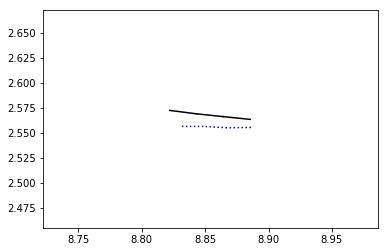

In [44]:
close_visualize(model,input_batch_padded,target_batch_padded,INPUT_LENGTH)